# Assignment 10: Review

We will review material covered so far in this course with short questions similar to what you might expect on the Final Exam. 

First review the lecture notes. Then try to do this assignment without referring to ANY external material to simulate exam conditions.

Setup for Q1

In [1]:
%load_ext sql

In [2]:
import pandas as pd
import numpy as np

In [3]:
from collections import OrderedDict

In [4]:
pid = ['a', 'c', 'a', 'b', 'c', 'a', 'c', 'c', 'a', 'a', 'b', 'b']
visit = [1, 1, 2, 1, 2, 3, 3, 4, 4, 5, 2, 3]
n = len(pid)

readings = pd.DataFrame(OrderedDict(pid=pid, visit=visit, sbp=np.random.normal(120, 25, n)))
readings['dbp'] = readings.sbp - np.random.normal(40, 10, n)

In [5]:
readings[['sbp', 'dbp']] = readings[['sbp', 'dbp']].astype('int')

In [6]:
patients = pd.DataFrame(OrderedDict(pid=['a', 'b', 'c', 'd'], ages=[23,34,45,56]))

In [7]:
%sql sqlite:///tables.db

'Connected: @tables.db'

In [8]:
%sql drop table patients
%sql persist patients

 * sqlite:///tables.db
Done.
 * sqlite:///tables.db


'Persisted patients'

In [9]:
%sql drop table readings
%sql persist readings

 * sqlite:///tables.db
Done.
 * sqlite:///tables.db


'Persisted readings'

In [10]:
%%sql

select * from patients

 * sqlite:///tables.db
Done.


index,ages,pid
0,23,a
1,34,b
2,45,c
3,56,d


In [11]:
%%sql 

select * from readings

 * sqlite:///tables.db
Done.


index,visit,pid,sbp,dbp
0,1,a,112,79
1,1,c,104,56
2,2,a,126,116
3,1,b,70,32
4,2,c,126,76
5,3,a,129,89
6,3,c,171,129
7,4,c,115,74
8,4,a,146,85
9,5,a,136,103


**1**. (20 points)

- Write an SQL statement to merge the patient and pressure tables using an inner join
- Write an SQL statement to find the average systolic (sbp) and diastolic (dbp) blood pressure for each patient, sorted in ascending order of sbp. The function to calculate averages in SQL is AVG.
- (optional - ungraded) Write an SQL statement to find the running average of systolic blood pressure for each patient across successive visits. Show the following columns pid, visit, sbp and running average of sbp. (NOTE: This will no work unless you have the version 3.2.5 or higher of SQLite3 or swithc to a database like PostgreSQL - in particular, it will not work on Docker. Just write the SQL even if it does not execute.)

In [12]:
%%sql

SELECT readings.pid, ages, sbp, dbp, visit FROM readings INNER JOIN patients
ON readings.pid = patients.pid

 * sqlite:///tables.db
Done.


pid,ages,sbp,dbp,visit
a,23,112,79,1
c,45,104,56,1
a,23,126,116,2
b,34,70,32,1
c,45,126,76,2
a,23,129,89,3
c,45,171,129,3
c,45,115,74,4
a,23,146,85,4
a,23,136,103,5


In [13]:
%%sql

SELECT pid, AVG(sbp), AVG(dbp) 
FROM readings
GROUP BY pid
ORDER BY AVG(sbp)

 * sqlite:///tables.db
Done.


pid,AVG(sbp),AVG(dbp)
b,117.0,74.66666666666667
c,129.0,83.75
a,129.8,94.4


**2**. (30 points)

- Use a raw count bag of words model for unigrams and bigrams to generate feature vectors for these two documents. For simplicity, you may tokenize by removing punctuation, splitting by white space to find words, and converting all words to lowercase. 
- Implement a function to calculate cosine *similarity* between two vectors without using any trigonometric functions, built-in distance functions or linear algebra modules. Find the cosine similarity between the two documents. Recall that the cosine similarity is the dot product of two unit vectors.

Only use the Python standard library and `numpy` to do this exercise.

In [14]:
doc1 = """As I was going by Charing Cross,
I saw a black man upon a black horse;
They told me it was King Charles the First-
Oh dear, my heart was ready to burst!"""

doc2 = """As I was going to St. Ives,
I met a man with seven wives,
Each wife had seven sacks,
Each sack had seven cats,
Each cat had seven kits:
Kits, cats, sacks, and wives,
How many were there going to St. Ives"""

In [15]:
def clean(string):
    return(string.replace(",", "").replace(";", "").replace("!", "").replace("-", "").replace(".", "").replace(":", "").lower().split())

In [16]:
def bigrams(input_list):
    bigram_list = []
    separator = " "
    for i in range(len(input_list) - 1):
        bigram_list.append(separator.join([input_list[i], input_list[i+1]]))
    return(bigram_list)

In [17]:
doc1_list = clean(doc1)
doc2_list = clean(doc2)

In [18]:
doc1_bag = dict()
doc2_bag = dict()
for i in doc1_list:
    doc1_bag[i] = doc1_bag.get(i, 0) + 1
for j in doc2_list:
    doc2_bag[j] = doc2_bag.get(j, 0) + 1
for k in bigrams(doc1_list):
    doc1_bag[k] = doc1_bag.get(k, 0) + 1
for m in bigrams(doc2_list):
    doc2_bag[m] = doc2_bag.get(m, 0) + 1

In [19]:
feature_vectors = pd.DataFrame.from_dict([doc1_bag, doc2_bag]).fillna(0).T
feature_vectors.columns = ['doc1', 'doc2']

In [20]:
feature_vectors.head()

,doc1,doc2
a,2.0,1.0
a black,2.0,0.0
a man,0.0,1.0
and,0.0,1.0
and wives,0.0,1.0


In [21]:
doc1_vector = feature_vectors['doc1'].values
doc2_vector = feature_vectors['doc2'].values

In [22]:
def norm(vector):
    "norm takes a 1-D numpy array and returns the norm of the vector since we are not allowed to use numpy.linalg.norm"
    return(np.sqrt((vector**2).sum()))

In [23]:
def cosine_similarity(vector1, vector2):
    """cosine_similarity takes two 1-D numpy arrays, normalizes them into unit vectors, and then
    takes the dot product to find the cosine similarity between the two vectors"""
    
    vector1 = vector1 / norm(vector1)
    vector2 = vector2 / norm(vector2)
    return(np.dot(vector1, vector2))

In [24]:
cosine_similarity(doc1_vector, doc2_vector)

0.1730209434769125

**3**. (30 points)

- Fit polynomials of order 2, 3 and 4 to the data set `x` and `y` by solving the normal equations $(X^TX) \hat{\beta} = X^Ty$. 
- Plot the fit against the data for each model.
- Calculate the sum of squares error for each model using leave one out cross-validation.

You may use `numpy.linalg` for this.

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [26]:
x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])

In [27]:
kf = KFold(n_splits = len(x)) # LOOCV

Order 2:

In [28]:
X_2 = np.vstack([np.ones_like(x), x, x**2]).T
beta = np.linalg.solve(X_2.T @ X_2, X_2.T @ y)

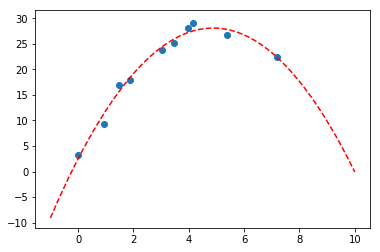

In [29]:
xs = np.linspace(-1, 10)
ys = np.vstack([np.ones_like(xs), xs, xs**2]).T @ beta

plt.plot(xs, ys, 'r--');
plt.scatter(x, y);

In [30]:
sse = np.empty([10, 2])
for train_indices, test_indices in kf.split(x, y):
    X_train = np.vstack([np.ones_like(x[train_indices]), x[train_indices], x[train_indices]**2]).T
    beta = np.linalg.solve(X_train.T @ X_train, X_train.T @ y[train_indices])
    
    X_test = np.array([np.ones_like(x[test_indices]), x[test_indices], x[test_indices]**2])
    y_pred = X_test.T @ beta
    
    sse[test_indices, :] = [((y[test_indices] - y_pred)**2).sum(), test_indices]

SSE's for each K-Fold:

In [31]:
sse[:, 0]

array([3.47523576, 0.42352807, 4.47311115, 0.43557419, 2.86776497,
       6.49503025, 0.30540979, 0.70276648, 1.15868664, 1.88419979])

Average SSE across all K-Folds:

In [32]:
sse[:, 0].mean()

2.222130709444699

Order 3:

In [33]:
X_3 = np.vstack([np.ones_like(x), x, x**2, x**3]).T
beta = np.linalg.solve(X_3.T @ X_3, X_3.T @ y)

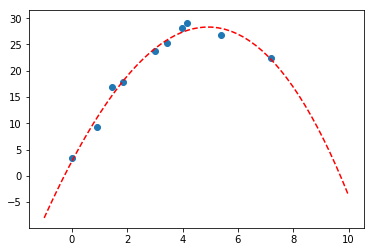

In [34]:
xs = np.linspace(-1, 10)
ys = np.vstack([np.ones_like(xs), xs, xs**2, xs**3]).T @ beta

plt.plot(xs, ys, 'r--');
plt.scatter(x, y);

In [35]:
sse = np.empty([10, 2])
for train_indices, test_indices in kf.split(x, y):
    X_train = np.vstack([np.ones_like(x[train_indices]), 
                         x[train_indices], x[train_indices]**2, x[train_indices]**3]).T
    beta = np.linalg.solve(X_train.T @ X_train, X_train.T @ y[train_indices])
    
    X_test = np.array([np.ones_like(x[test_indices]), 
                       x[test_indices], x[test_indices]**2, x[test_indices]**3])
    y_pred = X_test.T @ beta
    
    sse[test_indices, :] = [((y[test_indices] - y_pred)**2).sum(), test_indices]

SSE's for each K-Fold:

In [36]:
sse[:, 0]

array([ 3.38068694, 77.9324561 , 18.98448437,  0.33385374,  4.96260896,
        6.4234048 ,  0.14981008,  0.68982706,  1.00628048,  5.77180336])

Average SSE across all K-Folds:

In [37]:
sse[:, 0].mean()

11.963521588847131

Order 4:

In [38]:
X_4 = np.vstack([np.ones_like(x), x, x**2, x**3, x**4]).T
beta = np.linalg.solve(X_4.T @ X_4, X_4.T @ y)

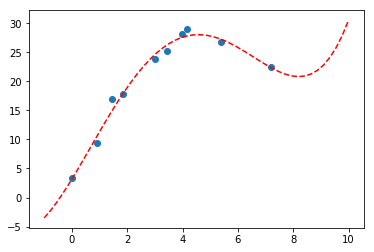

In [39]:
xs = np.linspace(-1, 10)
ys = np.vstack([np.ones_like(xs), xs, xs**2, xs**3, xs**4]).T @ beta

plt.plot(xs, ys, 'r--');
plt.scatter(x, y);

In [40]:
sse = np.empty([10, 2])
for train_indices, test_indices in kf.split(x, y):
    X_train = np.vstack([np.ones_like(x[train_indices]), 
                         x[train_indices], x[train_indices]**2, x[train_indices]**3, x[train_indices]**4]).T
    beta = np.linalg.solve(X_train.T @ X_train, X_train.T @ y[train_indices])
    
    X_test = np.array([np.ones_like(x[test_indices]), 
                       x[test_indices], x[test_indices]**2, x[test_indices]**3, x[test_indices]**4])
    y_pred = X_test.T @ beta
    
    sse[test_indices, :] = [((y[test_indices] - y_pred)**2).sum(), test_indices]

SSE's for each K-Fold:

In [41]:
sse[:, 0]

array([2.84055692e+00, 4.52538953e+02, 2.30877244e+01, 1.48676641e+00,
       9.15148864e+00, 5.37983920e+00, 4.04908174e-02, 2.30370988e+00,
       5.21496510e-01, 1.32546463e+01])

Average SSE across all K-Folds:

In [42]:
sse[:, 0].mean()

51.06056720871506

The model with the lowest average SSE is the order 2 polynomial.

**4** (20 points)

- Write a gradient descent algorithm to fit a cubic polynomial to the data from question 3. Use a learning rate of 1e-5 and 1 million iterations, and start with a $\beta_0 = (1,10,1,1)$
- Use a JIT decorator to create a compiled version and report the fold-change improvement in run time. Use the timeit.timeit function with argument `number=1`, and use a lambda function to pass in a function that takes 0 arguments.
- Plot the fitted curve

In [43]:
from numba import jit, float64, int64
import timeit

In [44]:
def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = X @ beta
        epsilon = y - y_pred
        grad = Xt @ epsilon
        beta = np.add(beta, alpha * grad)
    return beta

In [45]:
@jit
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = X @ beta
        epsilon = y - y_pred
        grad = Xt @ epsilon
        beta += alpha * grad
    return beta

In [46]:
X = np.vstack([np.ones_like(x), x, x**2, x**3]).T
y = y.reshape(-1, 1)
beta = np.array([[1], [10], [1], [1]], dtype = 'float64')
α = float(1e-5)
niter = int(1e6)

In [47]:
np.allclose(gd(X, y, beta, α, niter), gd_numba(X, y, beta, α, niter))

True

In [48]:
%%timeit
gd(X, y, beta, α, niter)

3.61 s ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
gd_numba(X, y, beta, α, niter)

658 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
t1 = timeit.timeit(lambda : gd(X, y, beta, α, niter), number = 1)

In [51]:
t2 = timeit.timeit(lambda : gd_numba(X, y, beta, α, niter), number = 1)

The fold change is:

In [52]:
t1/t2

5.568519208762586

The JIT compiled version of the gradient descent function is much faster than the normal one.

In [53]:
β = gd_numba(X, y, beta, α, niter)
xs = np.linspace(-1, 10)
ys = np.vstack([np.ones_like(xs), xs, xs**2, xs**3]).T @ β

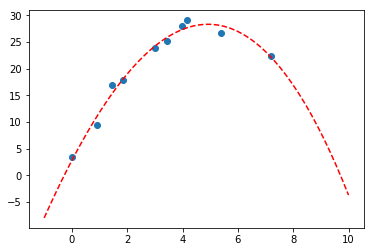

In [54]:
plt.scatter(x, y)
plt.plot(xs, ys, 'r--');